In [1]:
import bz2
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from tensorflow import keras
import pandas as pd
import gensim
from collections import Counter
from sklearn.decomposition import TruncatedSVD
PALABRAS = 100000
NUM_WORDS=100

2021-12-20 10:08:18.018934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-20 10:08:18.018962: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Conv2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.layers import Dense, Input, GRU, Embedding

In [3]:
silk_items = pd.read_csv("silkroad_items.csv")

In [4]:
boundary = silk_items["timestamp"][int((len(silk_items)-1)*0.8)]

In [7]:
top_50_categorias = (silk_items["category"].value_counts())[:50].keys()

In [9]:
categorias = list(silk_items["category"].unique())

In [10]:
dicc={}
for i in range(len(categorias)):
    dicc[categorias[i]] = i
dicc["misc"] = (len(categorias)+1)

In [11]:
silk_items["category"] = silk_items["category"].map(lambda x: dicc[x])

In [12]:
#silk_items["titulos + descripcion"] = silk_items["titulos + descripcion"].str.lower().map(lambda x: nltk.word_tokenize(x))

In [13]:
silk_items["titulos + descripcion"] = (silk_items["title"] + silk_items["description"]).str.lower().map(lambda x: nltk.word_tokenize(x))
#silk_items_train_test = silk_items_train.filter(["titulos + descripcion"])

In [14]:
silk_items_train = silk_items[silk_items["timestamp"] <= boundary].filter(["titulos + descripcion", "category"])
silk_items_validation = silk_items[silk_items["timestamp"] > boundary].filter(["titulos + descripcion", "category"])

In [15]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [16]:
emb_matrix = np.concatenate([np.zeros((1,300)), 
                             np.random.normal(size=(1,300)),
                             w2v_model.vectors[:PALABRAS]], axis=0)

In [17]:
silk_items_train_y = silk_items_train["category"]
silk_items_validation_y = silk_items_validation["category"]

In [18]:
x_train = list(silk_items_train["titulos + descripcion"])
x_val = list(silk_items_validation["titulos + descripcion"])

In [19]:
silk_items_train = None
silk_items_validation = None
silk_items = None

In [20]:
def preprocess_toks(textos_tokenizado):
    textos_tokenizado =textos_tokenizado.copy()
    max_len = int(np.percentile([len(t) for t in textos_tokenizado], 95))
    if len(textos_tokenizado) > max_len:
        textos_tokenizado = textos_tokenizado[:max_len]
    for i in range(len(textos_tokenizado)):
        if textos_tokenizado[i] in w2v_model and w2v_model.key_to_index[textos_tokenizado[i]]<PALABRAS:
            textos_tokenizado[i] = w2v_model.key_to_index[textos_tokenizado[i]]+2
        else:
            textos_tokenizado[i] = 1
    return textos_tokenizado

In [21]:
#w2v_model = None

In [22]:
silk_items = None

In [23]:

max_len = 100
for i in tqdm(range(len(x_train)), total=len(x_train)):
    x_train[i] = preprocess_toks(x_train[i])
x_train = pad_sequences(
    x_train, maxlen=max_len, dtype='int32', padding='post',
    truncating='post', value=0
)
word_indexes = Input((x_train.shape[1],), dtype='int32')
word_emb = Embedding(PALABRAS+2, 300, weights=[emb_matrix], 
                     trainable=False, mask_zero=True)

emb_sequence = word_emb(word_indexes) 
rnn1 = GRU(100, activation='tanh')(emb_sequence) 
dense1 = Dense(50, activation='sigmoid')(rnn1)

out = Dense(len(dicc), activation="softmax")(dense1)
model = Model(inputs=word_indexes, outputs=out)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(x_train, silk_items_train_y.values, validation_split=0.1, epochs=20, batch_size=256)


100%|████████████████████████████████| 320875/320875 [00:28<00:00, 11286.55it/s]
2021-12-20 10:14:56.989274: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-20 10:14:56.991169: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-20 10:14:56.995346: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bruno-VirtualBox): /proc/driver/nvidia/version does not exist
2021-12-20 10:14:57.026329: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
1129/1129 [==============================] - 167s 145ms/step - loss: 3.2731 - accuracy: 0.2902 - val_loss: 2.0922 - val_accuracy: 0.5244
Epoch 2/20
1129/1129 [==============================] - 167s 148ms/step - loss: 2.0609 - accuracy: 0.5460 - val_loss: 1.4948 - val_accuracy: 0.6780
Epoch 3/20
1129/1129 [==============================] - 166s 147ms/step - loss: 1.6216 - accuracy: 0.6354 - val_loss: 1.2206 - val_accuracy: 0.7419
Epoch 4/20
1129/1129 [==============================] - 165s 146ms/step - loss: 1.4081 - accuracy: 0.6702 - val_loss: 1.0769 - val_accuracy: 0.7730
Epoch 5/20
1129/1129 [==============================] - 167s 148ms/step - loss: 1.2551 - accuracy: 0.6965 - val_loss: 0.9895 - val_accuracy: 0.7924
Epoch 6/20
1129/1129 [==============================] - 163s 145ms/step - loss: 1.1476 - accuracy: 0.7140 - val_loss: 0.9229 - val_accuracy: 0.8061
Epoch 7/20
1129/1129 [==============================] - 162s 143ms/step - loss: 1.0678 - accuracy: 0.7264 - val_

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          30000600  
                                                                 
 gru (GRU)                   (None, 100)               120600    
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 306)               15606     
                                                                 
Total params: 30,141,856
Trainable params: 141,256
Non-trainable params: 30,000,600
_________________________________________________________________


In [25]:
import pickle
with open('model_backup', 'wb') as model_backup_file:
    pickle.dump(model, model_backup_file)

2021-12-20 11:07:50.112325: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://b672541f-300b-4374-8c2d-b9478adc33c6/assets


INFO:tensorflow:Assets written to: ram://b672541f-300b-4374-8c2d-b9478adc33c6/assets


In [26]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

In [27]:
for i in tqdm(range(len(x_val)), total=len(x_val)):
    x_val[i] = preprocess_toks(x_val[i])
x_val = pad_sequences(
    x_val, maxlen=max_len, dtype='int32', padding='post',
    truncating='post', value=0
)

100%|██████████████████████████████████| 80219/80219 [00:06<00:00, 12551.68it/s]


In [28]:
w2v_model = None

In [29]:
accuracy_score(silk_items_validation_y, np.argmax(model.predict(x_val),axis = 1))

0.8255276181453272

In [30]:
silk_items_validation_y = None
titulos_tokenizados = None
descripciones_tokenizadas = None
titulos_tokenizados_validation = None
descripciones_tokenizadas_validation = None

In [31]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [32]:
def prediccion(df, modelos):
    predicciones = []
    df_filter = df.filter(["title", "description"]).applymap(lambda x: nltk.word_tokenize(x.lower()))
    for columnas in df_filter.columns:
        columna_actual = list(df_filter[columnas])
        for i in tqdm(range(len((columna_actual))), total=len(columna_actual)):
            columna_actual[i] = preprocess_toks(columna_actual[i])
        columna_actual = pad_sequences(
            columna_actual, maxlen=100, dtype='int32', padding='post',
            truncating='post', value=0
        )
        predicciones.append(modelos.predict(columna_actual))
    prediccion = sum(predicciones)
    return np.argmax(prediccion ,axis = 1)

In [33]:
versus = pd.read_csv("versus.csv")

In [36]:
versus["Category"] = versus["Category"].map(lambda x: x if x in list(dicc.keys()) else "misc" ).map(lambda x: dicc[x])

In [37]:
versus_y = versus["Category"]

In [38]:
accuracy_score(versus_y, prediccion(versus, model))

100%|██████████████████████████████████| 16015/16015 [00:00<00:00, 19155.62it/s]


0.13512332188573212

In [39]:
import matplotlib.pyplot as plt
import numpy as np

In [55]:
versus = None

In [56]:
silk_items = pd.read_csv("silkroad_items.csv")["category"]

In [58]:
silk_items_categorys = silk_items.value_counts()

In [53]:
versus_categorys = versus_y.map(lambda x: list(dicc.keys())[x] if x!=306 else list(dicc.keys())[305]).value_counts()

In [62]:
silk_items_categorys=silk_items_categorys.filter(items=versus_categorys.index, axis= 0)

In [65]:
silk_items_categorys=silk_items_categorys.sort_index()
versus_categorys = versus_categorys.sort_index()

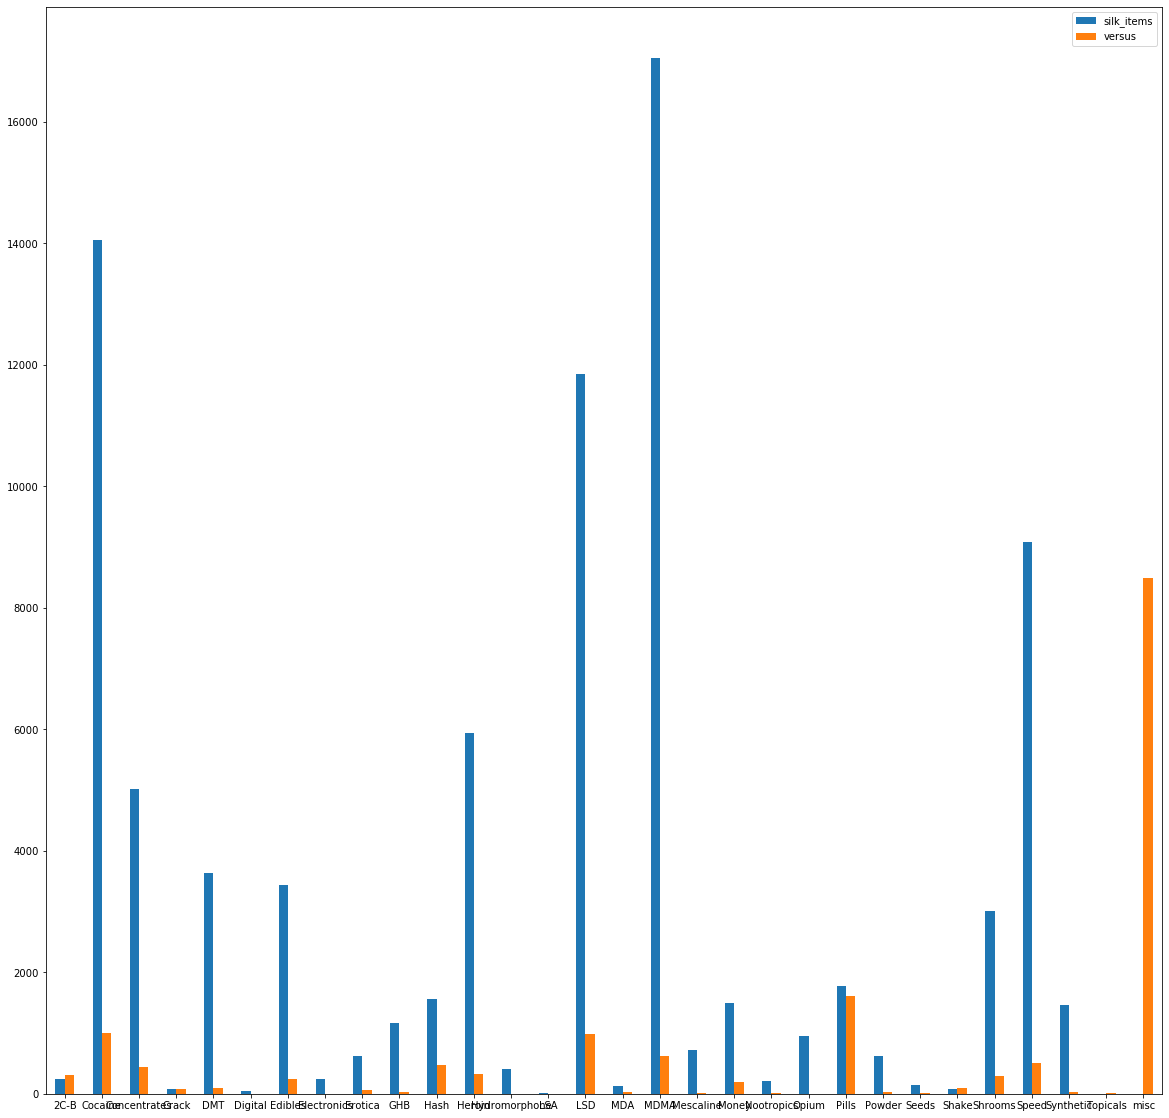

In [71]:
df = pd.DataFrame({'silk_items': silk_items_categorys,
                   'versus': versus_categorys}, index=versus_categorys.index)
ax = df.plot.bar(rot=0,  figsize=(20,20))